In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy
from scipy.optimize import curve_fit

from climada.hazard.low_flow import LowFlow

from climada.entity import ImpactFunc, ImpactFuncSet
from climada.entity.exposures import Exposures
from climada.engine import Impact
import datetime
import warnings
warnings.filterwarnings("ignore")

# New Attempt to get impact functions, using ISIMIP2a where the actual events should be seen


###            1. load hazard & exposures for the years& regions found in the literature research
###            2. change slope of impact function and calculate impacts until equivalent loss of production is found


In [2]:
#import filtered exposures
hydro = pd.read_excel('exposures/hydro_exposures.xlsx', index_col=0)
hydro = Exposures(hydro)
hydro.set_geometry_points()
hydro.check()

nuclear = pd.read_excel('exposures/nuclear_exposures.xlsx', index_col=0)
nuclear = Exposures(nuclear)
nuclear.set_geometry_points()

nuclear.check()

2020-07-02 12:57:06,925 - climada.util.coordinates - INFO - Setting geometry points.
2020-07-02 12:57:07,129 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-02 12:57:07,129 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-02 12:57:07,130 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-07-02 12:57:07,130 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2020-07-02 12:57:07,130 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-02 12:57:07,131 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-02 12:57:07,131 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-02 12:57:07,132 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-02 12:57:07,132 - climada.entity.exposures.base - INFO - cover not se

In [11]:
# function to get impact functions
def init_IFS_linear(s):
    """define impact function imp_fun and return impact function set (IFS)"""
    x0 = np.linspace(1,600,100)
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'LF'
    imp_fun.id = 1
    imp_fun.name = 'Low flow business interruption'
    imp_fun.intensity_unit = 'days'
    imp_fun.intensity = x0
    imp_fun.mdd = s*x0
    imp_fun.mdd[imp_fun.mdd>1]=1
    if s<=1/365:
        imp_fun.mdd[imp_fun.intensity>365] = s*x0[imp_fun.intensity>365]    
    else:
        imp_fun.mdd[imp_fun.intensity>365] = 1/365*x0[imp_fun.intensity>365]  

 # loss to annual operation
    imp_fun.paa = imp_fun.intensity * 0 + 1
   
    #imp_fun.paa[imp_fun.intensity<mdm] = 0
    imp_fun.check()
    IFS = ImpactFuncSet()
    IFS.append(imp_fun)
    return IFS

historical_data = pd.read_excel('historical_impacts_isimip2a.xlsx')


In [13]:
## function load hazards with only the parameters that we want to vary here

def make_hazard(percentile,yearrange,gh_model,cl_model,bbox):
    input_dir = '../data/isimip_data/'

    min_days_per_month = 5

    fn_str_var= 'co2_dis_global_daily'
    scenario = 'hist'
    soc = 'pressoc'
    yearrange_ref=[1981,2005]
    min_intensity=5
    min_number_cells=16

    hazard = LowFlow()
    hazard.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                            cl_model=cl_model,  bias_correction = 'ewembi',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                                min_intensity=min_intensity, min_number_cells=min_number_cells)
    hazard.check()
    return hazard

In [19]:
#input_dir = '../data/isimip_data/'
#min_days_per_month = 5
#percentile = 2.5
#fn_str_var= 'co2_dis_global_daily'
#scenario = 'hist'
#soc = 'pressoc'
#yearrange = [1990,2010]
#yearrange_ref=[1981,2005]
#bbox = [-15,30,50,72]
#min_intensity=5
#min_number_cells=16

#for percentile in [2.5,10]:
#    for gh_model in ['lpjml']: #matsiro does not have any data for soc='pressoc'
#        for cl_model in ['gswp3', 'wfdei']:

#            hazard = LowFlow()
#            hazard.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
#                                    cl_model=cl_model,  bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
#                                        min_intensity=min_intensity, min_number_cells=min_number_cells)
#            hazard.check()
#            hazard.write_hdf5('_'.join(['hazards/low_flow','europe',str(yearrange[0]),str(yearrange[1]),str(percentile),gh_model,cl_model,'.h5']))

   

In [ ]:

#for percentile in [2.5,10]:
#    for gh_model in ['h08']: #matsiro does not have any data for soc='pressoc'
#        for cl_model in ['gswp3','princeton']:

#            hazard = LowFlow()
#            hazard.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
#                                    cl_model=cl_model,  bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
#                                        min_intensity=min_intensity, min_number_cells=min_number_cells)
#            hazard.check()
#            hazard.write_hdf5('_'.join(['hazards/low_flow','europe',str(yearrange[0]),str(yearrange[1]),str(percentile),gh_model,cl_model,'.h5']))

   

# First testing some individual events

In [27]:
# get data for one climate and hydro model
hazard_2_5 = LowFlow()
hazard_2_5.read_hdf5('hazards/low_flow_europe_1990_2010_2.5_lpjml_gswp3.h5')
hazard_2_5.check()

hazard_10 = LowFlow()
hazard_10.read_hdf5('hazards/low_flow_europe_1990_2010_10_h08_gswp3.h5')
hazard_10.check()


2020-07-02 13:38:01,728 - climada.hazard.base - INFO - Reading hazards/low_flow_europe_1990_2010_2.5_lpjml_gswp3.h5
2020-07-02 13:38:01,738 - climada.hazard.base - INFO - Reading hazards/low_flow_europe_1990_2010_10_h08_gswp3.h5


# Spain 2005 Drought

In Spain, the 2005 drought led to a reduction of 36% in national hydroelectric power
production (equivalent to 12 876 GWh), with respect to the past five year average. The
decrease in hydraulic and nuclear production has been compensated by an increase in fuel-gas
plant production and combined cycles that increased their production by respectively 28% and
66%, compared to 2004. This extra production led to an additional cost of 713 Mio €. 
source: https://ec.europa.eu/environment/water/quantity/pdf/comm_droughts/2nd_int_report.pdf p.45

In [38]:
date0 = '2005-01-01'
daten = '2006-01-01' 
hazard_2_5.select(date=(date0,daten))
hazard_10.select(date=(date0,daten))

hydro_spain = hydro[hydro['country']=='ESP']
hydro_spain = Exposures(hydro_spain)
hydro_spain.check()

date0 = '2005-01-01'
daten = '2006-01-01' 

IFS_lf = init_IFS_linear(0.5)

imp_spain_2005 = Impact()
imp_spain_2005.calc(hydro_spain, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_spain_2005.at_event.sum()/(imp_spain_2005.tot_value)*100)

2020-07-02 13:39:36,844 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-02 13:39:36,845 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-02 13:39:36,845 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-02 13:39:36,846 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-02 13:39:36,846 - climada.entity.exposures.base - INFO - cover not set.
2020-07-02 13:39:36,846 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-02 13:39:36,847 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-02 13:39:36,851 - climada.entity.exposures.base - INFO - Matching 124 exposures with 10920 centroids.
2020-07-02 13:39:36,888 - climada.util.interpolation - WARNING - Distance to closest centroid is greater than 100km for 1 coordinates.
2020-07-02 13:39:36,890 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 15 events.
34.151

In [39]:

IFS_lf = init_IFS_linear(0.014)

date0 = '2005-01-01'
daten = '2006-01-01' 
imp_spain_2005 = Impact()
imp_spain_2005.calc(hydro_spain, IFS_lf, hazard_10.select(date=(date0,daten)))
print(imp_spain_2005.at_event.sum()/(imp_spain_2005.tot_value)*100)

2020-07-02 13:39:46,285 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-02 13:39:46,286 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
36.1919851202609


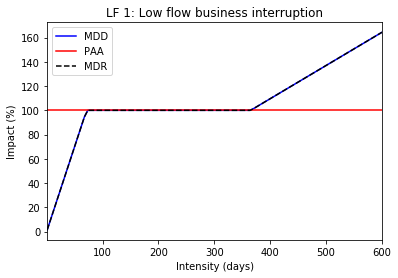

In [40]:
IFS_lf.plot() 

### Appears to work with the 10th percentile but the steepness of the impact function doesn't seem very realistic

## Germany 2003 ->11% loss of production

In [43]:
nuclear_germany = nuclear[nuclear['country_long']=='Germany']
nuclear_germany = Exposures(nuclear_germany)
nuclear_germany.check()

date0 = '2003-01-01'
daten = '2004-01-01' 

IFS_lf = init_IFS_linear(0.003)

imp_germany_2003 = Impact()
imp_germany_2003.calc(nuclear_germany, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_germany_2003.at_event.sum()/(imp_germany_2003.tot_value)*100)

2020-07-02 13:40:20,016 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-02 13:40:20,017 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-02 13:40:20,018 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-02 13:40:20,019 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-02 13:40:20,020 - climada.entity.exposures.base - INFO - cover not set.
2020-07-02 13:40:20,020 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-02 13:40:20,021 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-02 13:40:20,024 - climada.entity.exposures.base - INFO - Matching 5 exposures with 10920 centroids.
2020-07-02 13:40:20,034 - climada.engine.impact - INFO - Calculating damage for 5 assets (>0) and 13 events.
11.686543035783343


### looks much better

## checking 'normal' yrs for nuclear in germany

In [46]:
nuclear_germany = nuclear[nuclear['country_long']=='Germany']
nuclear_germany = Exposures(nuclear_germany)
nuclear_germany.check()

date0 = '1990-01-01'
daten = '2000-01-01' 

IFS_lf = init_IFS_linear(0.007)

imp_germany_2004_2010 = Impact()
imp_germany_2004_2010.calc(nuclear_germany, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_germany_2004_2010.at_event.sum()/(imp_germany_2004_2010.tot_value*10)*100)

2020-07-02 13:40:44,432 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-02 13:40:44,433 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-02 13:40:44,433 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-02 13:40:44,433 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-02 13:40:44,434 - climada.entity.exposures.base - INFO - cover not set.
2020-07-02 13:40:44,434 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-02 13:40:44,434 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-02 13:40:44,438 - climada.entity.exposures.base - INFO - Matching 5 exposures with 10920 centroids.
2020-07-02 13:40:44,447 - climada.engine.impact - INFO - Calculating damage for 5 assets (>0) and 108 events.
4.363540931807163


# France 2003 & 2006

## Les pertes de production ont atteint 5,5 TWh en 2003 et 2,5 TWh en 2006
https://www.sfen.org/rgn/adapter-centrales-nucleaires-changement-climatique

In [49]:
nuclear_france = nuclear[nuclear['country_long']=='France']
nuclear_france = Exposures(nuclear_france)
nuclear_france.check()

date0 = '2003-01-01'
daten = '2004-01-01' 

IFS_lf = init_IFS_linear(0.0006)

imp_france_2003 = Impact()
imp_france_2003.calc(nuclear_france, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_france_2003.at_event.sum()/1000) #(/1000 because the data is in GWh)

2020-07-02 13:41:04,127 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-02 13:41:04,130 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-02 13:41:04,131 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-02 13:41:04,132 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-02 13:41:04,134 - climada.entity.exposures.base - INFO - cover not set.
2020-07-02 13:41:04,134 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-02 13:41:04,135 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-02 13:41:04,143 - climada.entity.exposures.base - INFO - Matching 14 exposures with 10920 centroids.
2020-07-02 13:41:04,159 - climada.engine.impact - INFO - Calculating damage for 14 assets (>0) and 13 events.
5.981567464723585


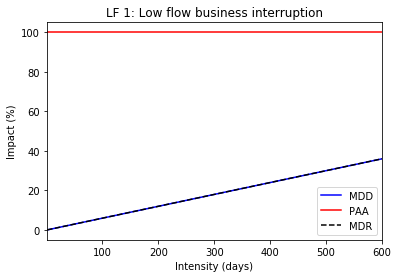

In [50]:
IFS_lf.plot() #very flat

In [52]:
nuclear_france = nuclear[nuclear['country_long']=='France']
nuclear_france = Exposures(nuclear_france)
nuclear_france.check()

date0 = '2006-01-01'
daten = '2007-01-01' 

IFS_lf = init_IFS_linear(0.002)

imp_france_2006_2007 = Impact()
imp_france_2006_2007.calc(nuclear_france, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_france_2006_2007.at_event.sum()/1000)

2020-07-02 13:41:12,488 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-02 13:41:12,489 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-02 13:41:12,489 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-02 13:41:12,489 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-02 13:41:12,490 - climada.entity.exposures.base - INFO - cover not set.
2020-07-02 13:41:12,490 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-02 13:41:12,490 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-02 13:41:12,494 - climada.entity.exposures.base - INFO - Matching 14 exposures with 10920 centroids.
2020-07-02 13:41:12,506 - climada.engine.impact - INFO - Calculating damage for 14 assets (>0) and 10 events.
0.0


# Europe 2003 6.6% loss hydro, 4.7% nuclear

In [60]:
#nuclear
date0 = '2003-01-01'
daten = '2004-01-01' 

IFS_lf = init_IFS_linear(0.002)

imp_eu_2003 = Impact()
imp_eu_2003.calc(nuclear, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_eu_2003.at_event.sum()/(imp_eu_2003.tot_value)*100)

2020-07-02 13:42:12,838 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-02 13:42:12,839 - climada.engine.impact - INFO - Calculating damage for 46 assets (>0) and 13 events.
4.541847053880298


In [59]:
#hydro
date0 = '2003-01-01'
daten = '2004-01-01' 

IFS_lf = init_IFS_linear(0.004)

imp_eu_2003 = Impact()
imp_eu_2003.calc(hydro, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_eu_2003.at_event.sum()/(imp_eu_2003.tot_value)*100)

2020-07-02 13:42:02,235 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-02 13:42:02,238 - climada.engine.impact - INFO - Calculating damage for 2092 assets (>0) and 13 events.
5.126178520958528


# now making a function which looks for the right slope of the impact function of each event for given gh model/ cl model

In [68]:

def if_finder(historical_data, hazard, exposures, input_dir=None, centroids=None,
                    bbox=None, percentile=2.5, min_intensity=5, min_number_cells=16,
                    min_days_per_month=5, yearrange_ref=[1981,2010],
                    gh_model='h08', cl_model='gswp3',
                    scenario='hist', scenario_ref='hist', soc='pressoc', \
                    fn_str_var='co2_dis_global_daily', bias_correction = 'nobc'):
    
    
    
    energies = historical_data['Energy'].unique()
   
    slope_list = []
    for index, row in historical_data.iterrows():
        year0 = historical_data['date0'][index].year
        yearn = historical_data['daten'][index].year
        yearrange = [year0,yearn]
        exposuresn = exposures[historical_data['Energy'][index]]
        country = historical_data['Country'][index].split(',')
        exposuresn = exposuresn[exposuresn.country_long.isin(country)]
        exposuresn = Exposures(exposuresn)
        exposuresn.check()
        hazardn = hazard.select(date=(historical_data['date0'][index].toordinal(),historical_data['daten'][index].toordinal()))
        slope=0.0005
        impacts_sum = 0
        while historical_data['loss'][index]>impacts_sum:
            print(impacts_sum)
            slope = slope + 0.0005
            if slope > 0.01: # break in case the slope becomes too large to make sense
                slope = 'NA'
                break
            impact_function = init_IFS_linear(slope)
            impact = Impact()
            impact.calc(exposuresn, impact_function, hazardn)
            if historical_data['unit'][index]=='percentage':
                impacts_sum = impact.at_event.sum()/(impact.tot_value*(yearn-year0))*100
            else:
                impacts_sum = impact.at_event.sum()
        slope_list.append(slope)
    historical_data["_".join(['slope_if',gh_model,cl_model])] = slope_list
    return(historical_data)
   

In [ ]:
historical_data = pd.read_excel('historical_impacts_isimip2a.xlsx', index_col=0)

input_dir = '../data/isimip_data/'
year0 = np.min(historical_data['date0']).year
yearn = np.max(historical_data['daten']).year
yearrange=[year0,yearn]


min_days_per_month = 5
percentile = 2.5
#gh_model = 'h08'
cl_model = 'gswp3'
fn_str_var= 'co2_dis_global_daily'
scenario = 'hist'
soc = 'pressoc'
yearrange_ref=[1981,2005]
bbox = [-15,30,50,72]
min_intensity=5
min_number_cells=16

exposures = {'Hydro': hydro, 'Nuclear': nuclear}

for gh_model in ['lpjml']: #matsiro does not have any data for soc='pressoc'
    for cl_model in ['gswp3','wfdei']:
        
        print(gh_model)
        hazard = LowFlow()
        hazard.read_hdf5("".join(['hazards/low_flow_europe_1990_2010_2.5_', gh_model, '_', cl_model, '.h5']))
        hazard.check()

        historical_data = if_finder(historical_data.loc[0:12], hazard, exposures, input_dir=input_dir, bbox=bbox, gh_model=gh_model,cl_model=cl_model)
for gh_model in ['h08']: #matsiro does not have any data for soc='pressoc'
    for cl_model in ['gswp3','princeton']:

        print(gh_model)
        hazard = LowFlow()
        hazard.read_hdf5("".join(['hazards/low_flow_europe_1990_2010_2.5_', gh_model, '_', cl_model, '.h5']))
        hazard.check()

        historical_data = if_finder(historical_data.loc[0:12], hazard, exposures, input_dir=input_dir, bbox=bbox, gh_model=gh_model,cl_model=cl_model)




In [4]:
historical_data['if_slope'] = historical_data.replace('NA',float('nan')).iloc[:,8:12].mean(axis=1)

In [25]:
historical_data


,Energy,Country,date0,daten,loss,unit,slope_if_lpjml_gswp3,slope_if_h08_gswp3,slope_if_h08_princeton,slope_if_lpjml_wfdei,if_slope
0,Hydro,Portugal,2005-01-01,2006-01-01,21.0,percentage,NaN,NaN,NaN,0.003,NaN
1,Hydro,Spain,2005-01-01,2006-01-01,37.5,percentage,NaN,NaN,NaN,NaN,NaN
2,Hydro,France,2005-01-01,2006-01-01,10000.0,Gwh,NaN,0.003,0.003,0.003,0.0030
3,Hydro,Albania,2003-01-01,2004-01-01,33.0,percentage,NaN,NaN,NaN,NaN,NaN
4,Hydro,Spain,2004-01-01,2008-01-01,17.0,percentage,NaN,NaN,NaN,NaN,NaN
5,Hydro,"Finland, Sweden, Norway",2002-01-01,2003-01-01,7.8,percentage,0.007,0.002,0.002,NaN,0.0045
6,Hydro,"Finland, Sweden, Norway",1996-01-01,1997-01-01,21.3,percentage,NaN,0.006,0.004,NaN,0.0060
7,Hydro,Spain,1992-01-01,1994-01-01,14.5,percentage,NaN,NaN,NaN,NaN,NaN
8,Nuclear,France,2003-01-01,2004-01-01,5500.0,Gwh,0.002,0.002,0.002,NaN,0.0020
9,Nuclear,France,2006-01-01,2007-01-01,2500.0,Gwh,0.002,0.002,0.002,0.002,0.0020


Text(0.5, 1.0, 'Hydro')

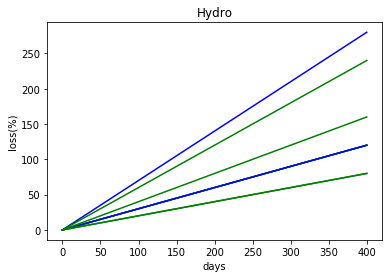

In [126]:
x0 = np.linspace(0,400,20)
fig,ax = plt.subplots()
c=1



for index, row in historical_data[historical_data['Energy']=='Hydro'].iterrows():
                
    for gh_model in ['h08']: #matsiro does not have any data for soc='pressoc'
        for cl_model in ['gswp3','princeton']:    
            if historical_data['_'.join(['slope_if',gh_model,cl_model])][index] !='NA':
                ax.plot(x0,x0*historical_data['_'.join(['slope_if',gh_model,cl_model])][index]*100,color='Green')             

    
    
    for gh_model in ['lpjml']: #matsiro does not have any data for soc='pressoc'
        for cl_model in ['gswp3','wfdei']:    
            if historical_data['_'.join(['slope_if',gh_model,cl_model])][index] !='NA':
                ax.plot(x0,x0*historical_data['_'.join(['slope_if',gh_model,cl_model])][index]*100,color='Blue')             
    
ax.set_xlabel('days')
ax.set_ylabel('loss(%)')
ax.set_title('Hydro')
 #blue is lpjml, green h08, no noticable pattern

Text(0.5, 1.0, 'Nuclear')

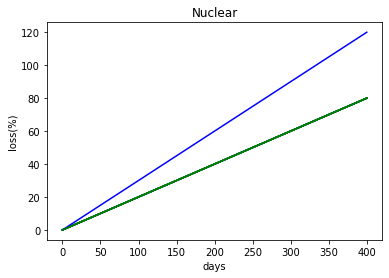

In [123]:
x0 = np.linspace(0,400,20)
fig,ax = plt.subplots()
for index, row in historical_data[historical_data['Energy']=='Nuclear'].iterrows():
    for gh_model in ['lpjml']: #matsiro does not have any data for soc='pressoc'
        for cl_model in ['gswp3','wfdei']:    
            if historical_data['_'.join(['slope_if',gh_model,cl_model])][index] !='NA':
                ax.plot(x0,x0*historical_data['_'.join(['slope_if',gh_model,cl_model])][index]*100, color ='Blue')
                
    for gh_model in ['h08']: #matsiro does not have any data for soc='pressoc'
        for cl_model in ['gswp3','princeton']:    
            if historical_data['_'.join(['slope_if',gh_model,cl_model])][index] !='NA':
                ax.plot(x0,x0*historical_data['_'.join(['slope_if',gh_model,cl_model])][index]*100, color='Green')             

ax.set_xlabel('days')
ax.set_ylabel('loss(%)')
ax.set_title('Nuclear')     

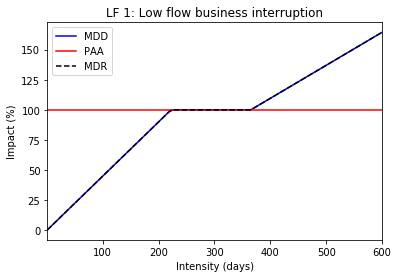

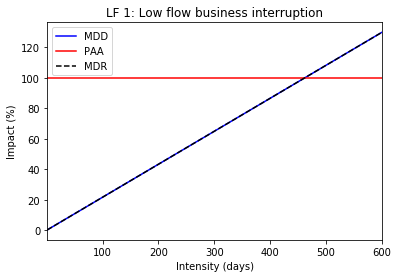

In [12]:
IFS_hydro = init_IFS_linear(historical_data['if_slope'][historical_data['Energy']=='Hydro'].mean())
IFS_thermo = init_IFS_linear(historical_data['if_slope'][historical_data['Energy']=='Nuclear'].mean())
IFS_hydro.plot()
IFS_thermo.plot()

In [111]:
historical_data = pd.read_excel('historical_impacts_isimip2a.xlsx', index_col=0)

isimip2a_isimip2b_slopes = pd.read_excel('slopes_isimip2a_isimip2b.xlsx', index_col=0)


In [127]:
isimip2a_isimip2b_slopes

,gh_model,thermo_isimip2a,hydro_isimip2a,thermo_isimip2b,hydro_isimip2b
0,matsiro,NaN,NaN,0.000284,0.002569
1,h08,0.002333,0.004333,0.000560,0.002612
2,lpjml,0.002000,0.003333,0.000673,0.002995


In [108]:
historical_data[['slope_if_lpjml_gswp3', 'slope_if_lpjml_wfdei']][historical_data['Energy']=='Hydro'].mean(axis=1).mean()

0.004333333333333334

In [112]:
isimip2a_isimip2b_slopes.loc[1,'hydro_isimip2a'] = historical_data[['slope_if_lpjml_gswp3', 'slope_if_lpjml_wfdei']][historical_data['Energy']=='Hydro'].mean(axis=1).mean()

isimip2a_isimip2b_slopes.loc[1,'thermo_isimip2a'] = historical_data[['slope_if_lpjml_gswp3', 'slope_if_lpjml_wfdei']][historical_data['Energy']=='Nuclear'].mean(axis=1).mean()

isimip2a_isimip2b_slopes.loc[2,'hydro_isimip2a'] = historical_data[['slope_if_h08_gswp3', 'slope_if_h08_princeton']][historical_data['Energy']=='Hydro'].mean(axis=1).mean()

isimip2a_isimip2b_slopes.loc[2,'thermo_isimip2a'] = historical_data[['slope_if_h08_gswp3', 'slope_if_h08_princeton']][historical_data['Energy']=='Nuclear'].mean(axis=1).mean()

In [125]:
isimip2a_isimip2b_slopes.to_excel('slopes_isimip2a_isimip2b.xlsx')

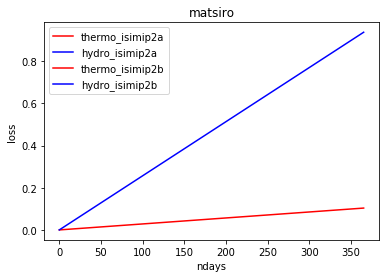

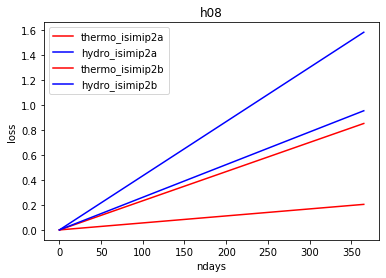

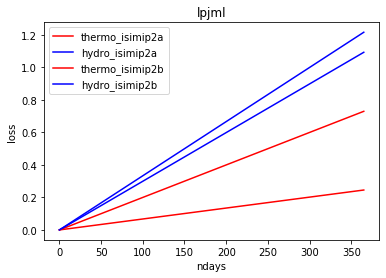

In [114]:
x0 = np.linspace(0,365,20)

color = ['red','blue']
for b in isimip2a_isimip2b_slopes.index:
    c=0
    fig,ax = plt.subplots()
    for a in isimip2a_isimip2b_slopes.columns[1:]:
        ax.plot(x0,x0*isimip2a_isimip2b_slopes[a][b],label=a, color= color[c])
        c = c+1
        if c==2:
            c=0
        
    ax.set_title(isimip2a_isimip2b_slopes['gh_model'][b])
    ax.set_xlabel('ndays')
    ax.set_ylabel('loss')
    ax.legend()